<a href="https://colab.research.google.com/github/Srinivas-gali/Anpr/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install required packages

In [ ]:
!pip install easyocr
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import necessary libraries

In [ ]:
import cv2
import numpy as np
import imutils
import easyocr
import pandas as pd
from matplotlib import pyplot as plt

# Load the image

In [ ]:
image_path = '/content/c43.jpg'
img = cv2.imread(image_path)

# Convert image to grayscale

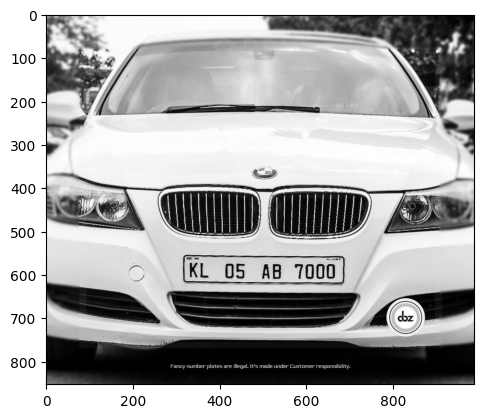

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.show()

# Apply bilateral filtering for noise reduction

In [ ]:
filtered = cv2.bilateralFilter(gray, 11, 17, 17)

# Perform edge detection using Canny

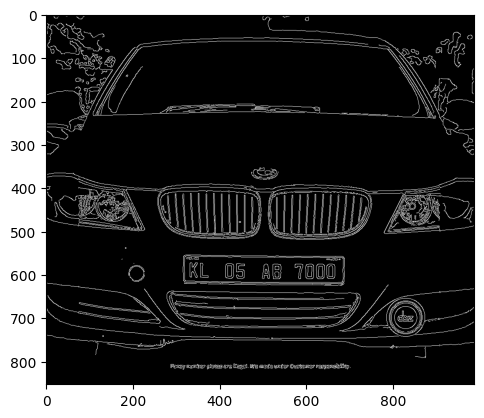

In [ ]:
edged = cv2.Canny(filtered, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

# Find contours in the image and sort them by area

In [ ]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Locate the number plate contour

In [ ]:
plate_location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        plate_location = approx
        break

# Create a mask to extract the number plate region

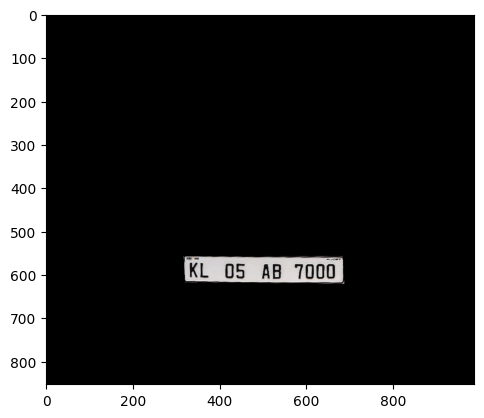

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
mask = cv2.drawContours(mask, [plate_location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

# Crop the number plate region

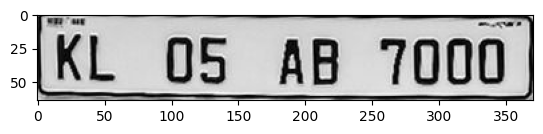

In [ ]:
(x, y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# Perform text recognition using EasyOCR

In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
text = result[0][-2]
text

'KL'

# Store the recognized text in an Excel file

In [ ]:
data = {'Number Plate Text': [text]}
df = pd.DataFrame(data)

# Check if the Excel file already exists

In [ ]:
try:
    existing_df = pd.read_excel('number_plate_text.xlsx')
    updated_df = pd.concat([existing_df, df], ignore_index=True)
    updated_df.to_excel('number_plate_text.xlsx', index=False)
    print("Data appended to the existing file.")
except FileNotFoundError:
    df.to_excel('number_plate_text.xlsx', index=False)
    print("New file created.")

Data appended to the existing file.


# Display the number plate text on the original image

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
image_with_text = cv2.putText(img, text=text, org=(plate_location[0][0][0], plate_location[1][0][1]+60),fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
image_with_rectangle = cv2.rectangle(img, tuple(plate_location[0][0]), tuple(plate_location[2][0]), (0, 255, 0), 3)


# Display the processed image with the number plate text

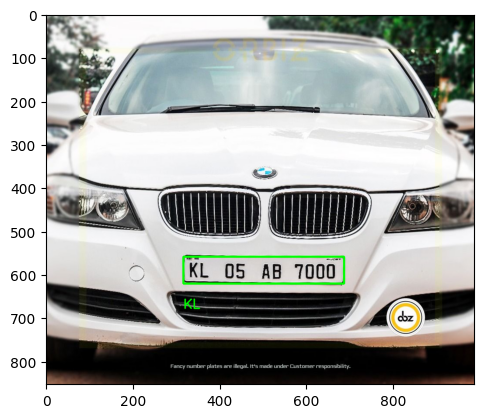

In [ ]:
plt.imshow(cv2.cvtColor(image_with_rectangle, cv2.COLOR_BGR2RGB))
plt.show()